In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
pd.set_option('display.min_rows', 100)

In [3]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.colormaps.get_cmap(name)(np.linspace(0, 0.9, n))

In [4]:
def rps_from_send_interval(interval_ms, batch_size = 64):
    return 1000 / interval_ms * batch_size

In [5]:
def send_inteval_from_rps(rps, batch_size=64):
    return 1000 / rps * batch_size

In [20]:
rps_from_send_interval(1150)

55.65217391304348

In [19]:
send_inteval_from_rps(55)

1163.6363636363637

In [8]:
with open("metrics_cluster_batching_cached_no_cc_64b_12n_4cu_1420si_6_excluded_slow.json") as f:
    raw = json.load(f)
points = pd.json_normalize(raw)
points.rename(columns={
    "labels.status": "status", 
    "labels.sender": "sender",
    "labels.nonce": "nonce",
    "labels.size": "size",
    "labels.batch": "id",
    "labels.node": "node"
}, inplace=True)
points["end"] = points['start'] + points['duration']
points.sort_values(by='start', inplace=True)

In [9]:
success = points[points["status"] == "success"]
confirmed = points[points["status"] == "confirmed"]

In [10]:
success.shape

(422, 13)

In [11]:
confirmed.shape

(422, 13)

In [12]:
success["duration"].median()

6541.444845199585

In [13]:
confirmed["duration"].median()

28899.77546787262

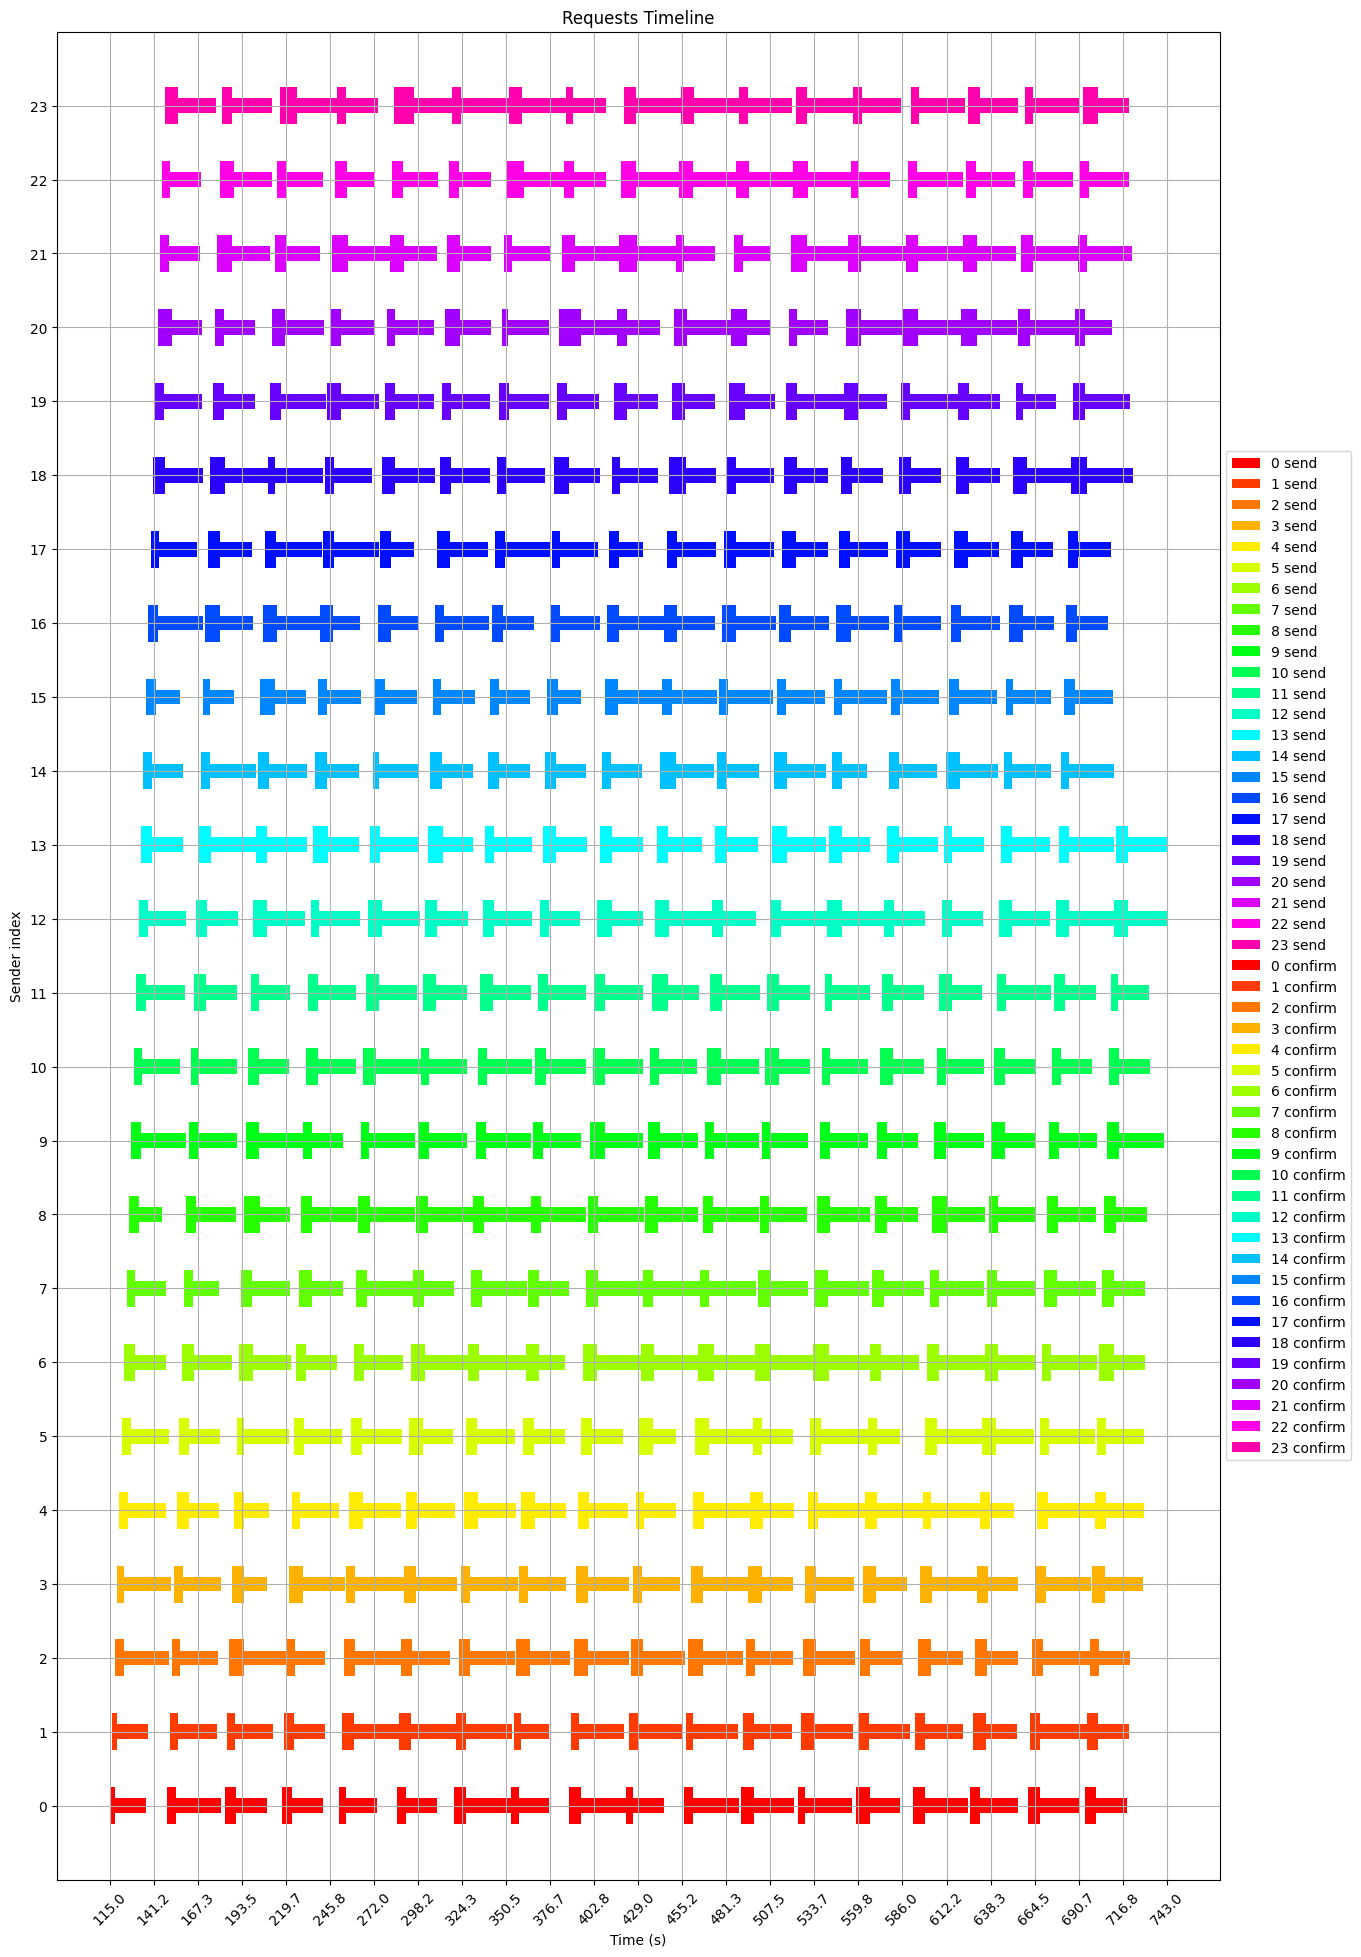

In [14]:
FACTOR = 1e3
count = len(points['sender'].unique())
plt.figure(figsize=(15, count))
cmap = get_cmap(count)

def plot_duration(data, name, th, colors):
    for i, (pnum, group) in enumerate(data.groupby('sender')):
        data = list(zip(group['start'] / FACTOR, group['duration']  / FACTOR))
        label = str(pnum) + " " + name
        color = colors if isinstance(colors, str) else colors[i]
        plt.broken_barh(data, (pnum-th/2, th), facecolor=color, label=label)

plot_duration(success, "send", 0.5, cmap)
plot_duration(confirmed, "confirm", 0.2, cmap)

# Formatting
plt.xticks(np.linspace(confirmed["start"].min() / FACTOR, confirmed["end"].max() / FACTOR, 25), rotation=45)
plt.yticks(np.linspace(0, count - 1, count))

plt.xlabel('Time (s)')
plt.ylabel('Sender index')
plt.title('Requests Timeline')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-1, count)
plt.grid(True)
plt.show()

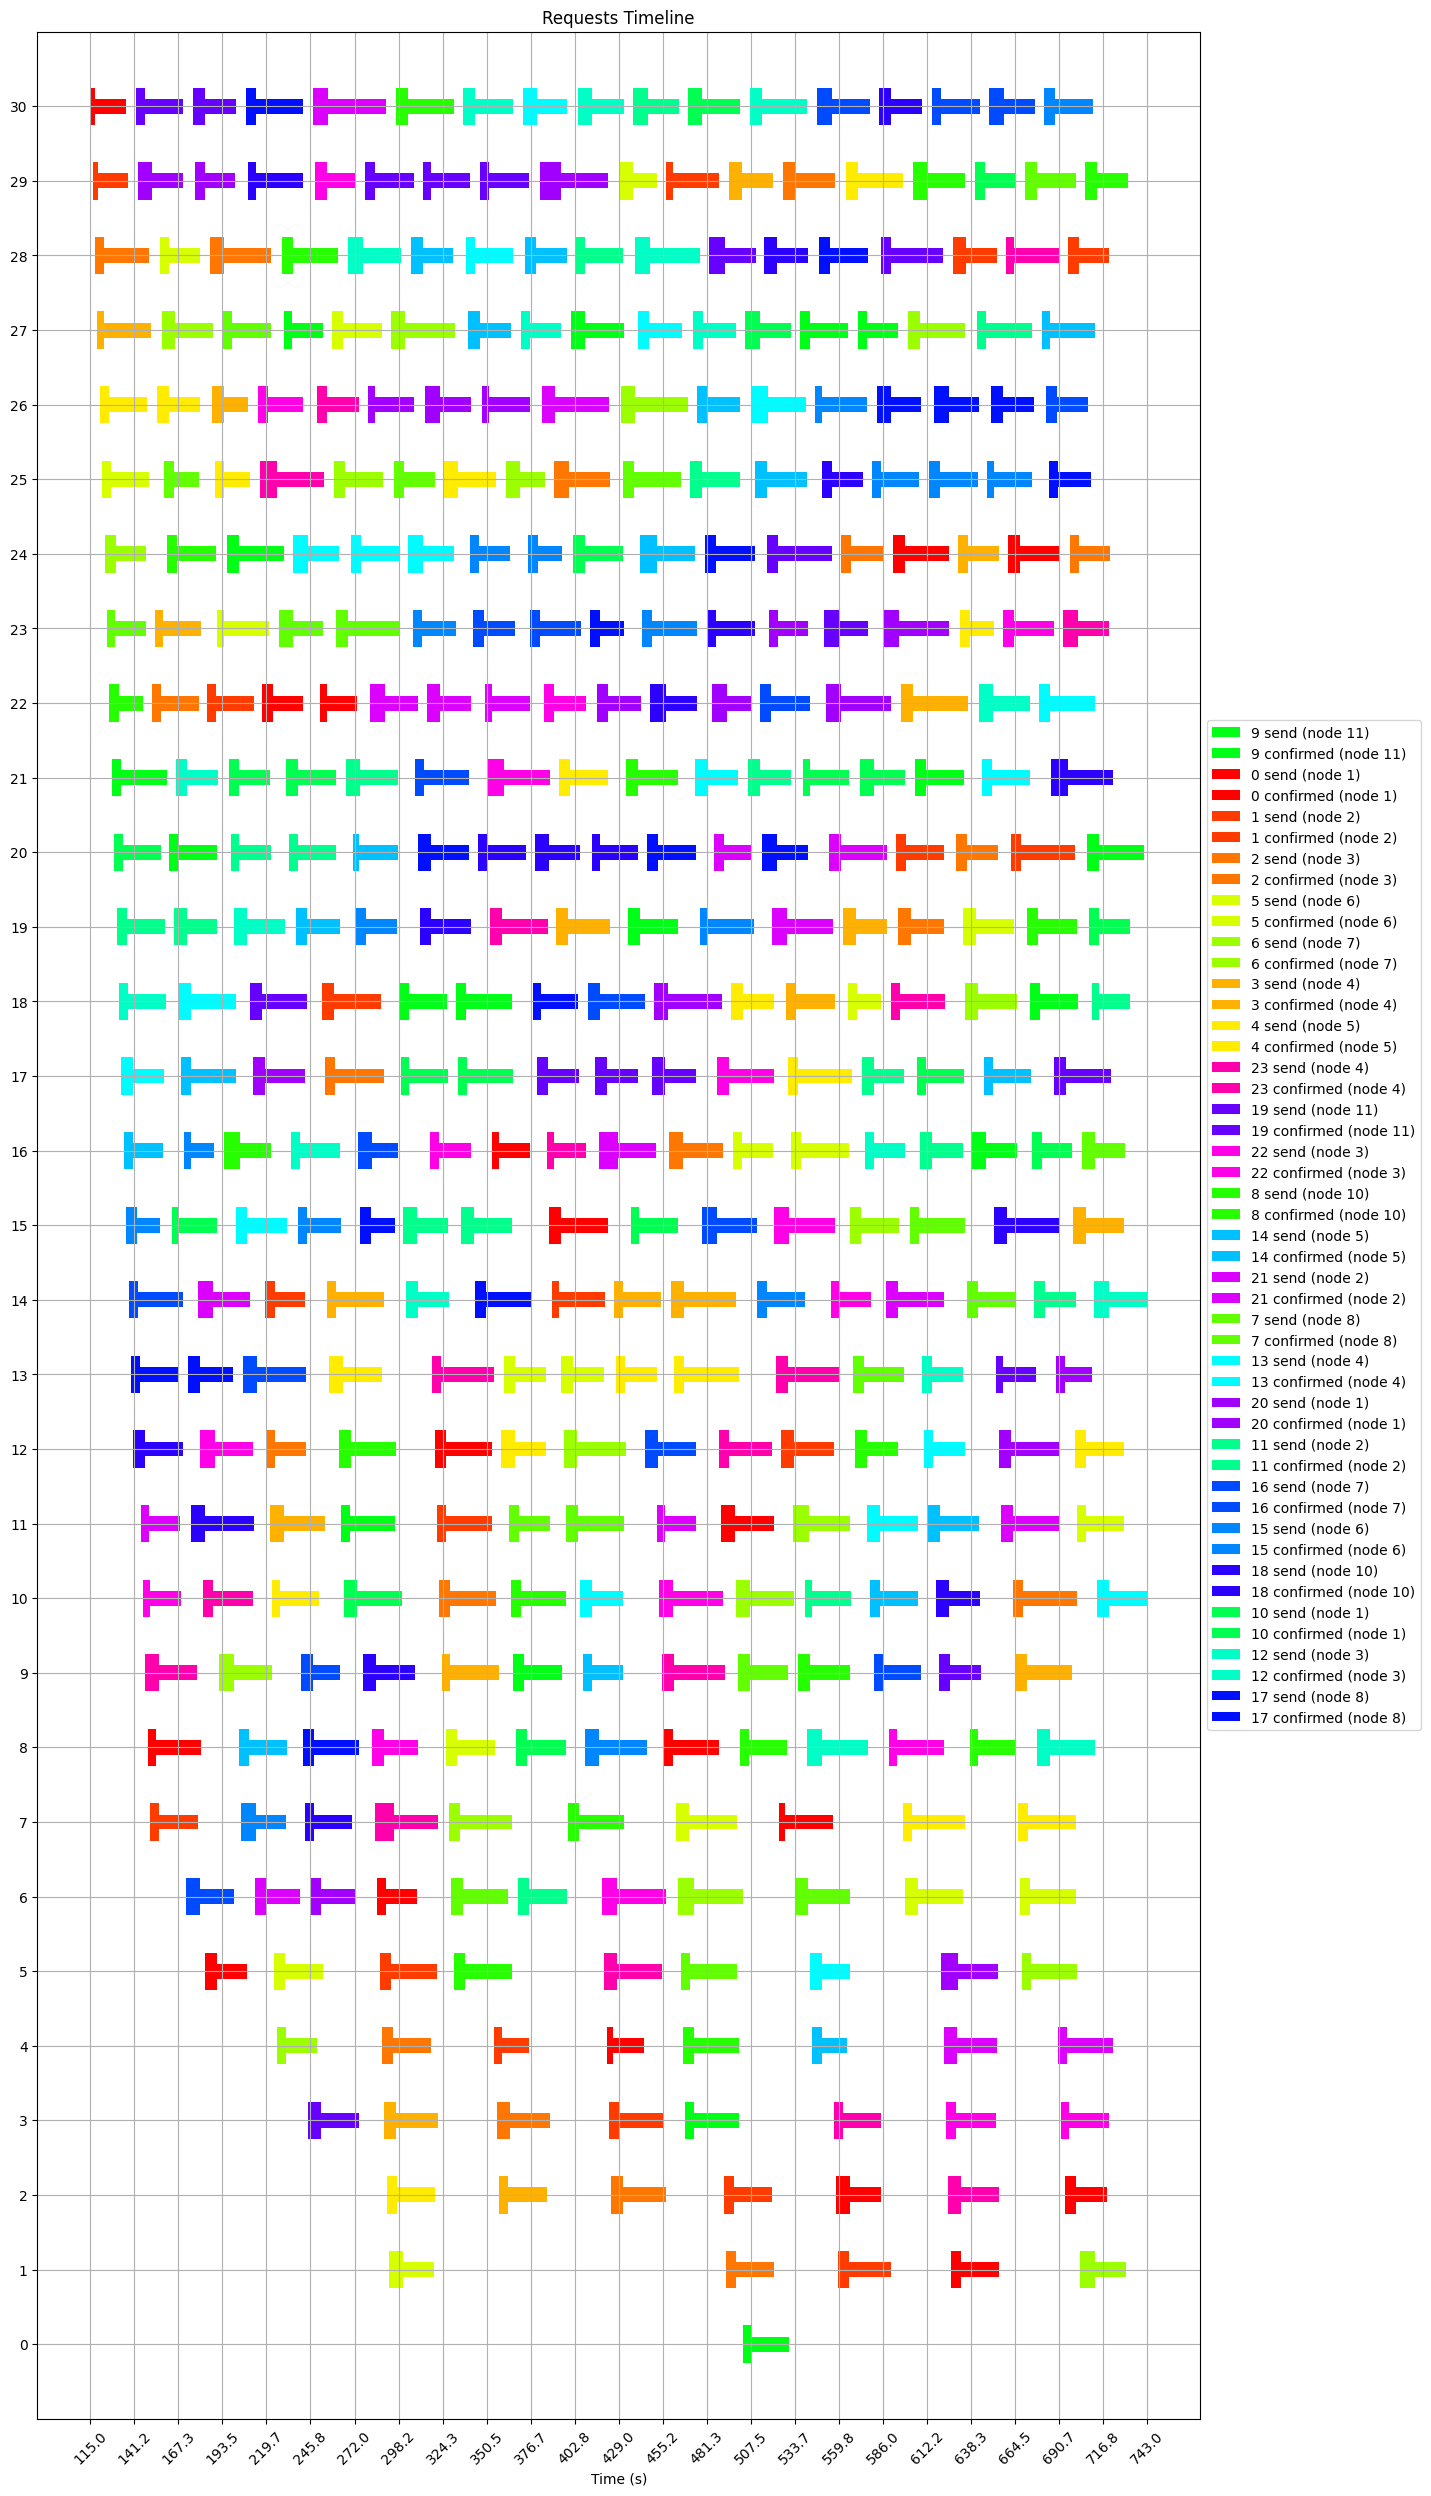

In [15]:
threshold = 5e3
lines = []
def place_in_lines(group):
    start = group['start'].min()
    end = group['end'].max()
    
    placed = False
    for i, line in enumerate(lines):
        line_end, line_groups = line
        if line_end + threshold < start:
            line_groups.append(group)
            lines[i] = (end, line_groups)
            placed = True
            break

    if not placed:
        lines.append((end, [group]))

groups = points.groupby('id')

# quantile = groups.apply(
#     lambda g: g['duration'].max(),
#     include_groups = False
# ).quantile(0.99)
quantile = float("inf")
long_groups = []

for _, group in groups:
    duration = group['duration'].max()

    if duration > quantile:
        long_groups.append(group)
    else:
        place_in_lines(group)

for group in long_groups:
    place_in_lines(group)

lines = [pd.concat(groups) for _, groups in lines]

FACTOR = 1e3
senders = len(points['sender'].unique())
cmap = get_cmap(senders)

plt.figure(figsize=(15, len(lines)))

labels = set()
def plot_line(i, line):
    def plot_pdata(pdata, th, label, color):
        data = list(zip(pdata['start'] / FACTOR, pdata['duration']  / FACTOR))
        plt.broken_barh(data, (i-th/2, th), facecolor=color, label=label if not label in labels else "")
        labels.add(label)
    
    for pnum, pdata in line.groupby('sender'):
        nodes = pdata['node'].unique()
        assert(len(nodes) == 1)
        node = nodes[0]
        sent = pdata[pdata["status"] == "success"]
        confirmed = pdata[pdata["status"] == "confirmed"]
        retries = pdata[~pdata["status"].isin(["success", "confirmed"])]
        color = cmap[pnum]
        plot_pdata(sent, 0.5, f"{pnum} send (node {node})", color)
        plot_pdata(confirmed, 0.2, f"{pnum} confirmed (node {node})", color)
        
        plt.scatter(retries['end'] / FACTOR, [i] * len(retries), color="black")

for i, line in enumerate(reversed(lines)):
    plot_line(i, line)

# Formatting
plt.xticks(np.linspace(confirmed["start"].min() / FACTOR, confirmed["end"].max() / FACTOR, 25), rotation=45)
plt.yticks(np.linspace(0, len(lines) - 1, len(lines)))

plt.xlabel('Time (s)')
plt.title('Requests Timeline')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylim(-1, len(lines))
plt.grid(True)
plt.show()

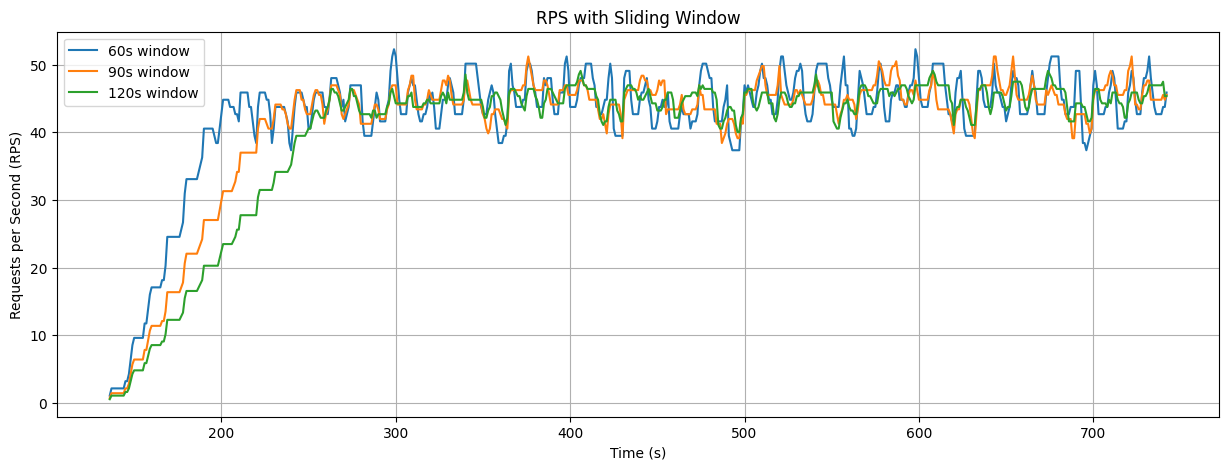

In [16]:
reqs = confirmed[["end", "size"]].copy()
reqs["end"] = pd.to_timedelta(reqs["end"], unit="ms")
reqs = reqs.groupby("end")["size"].sum()

# Resample to 1-second frequency
resampled = reqs.resample('1s').sum()

FACTOR = 1e9
def plot_window(window_size):
    rps = resampled.rolling(window=window_size, min_periods=0).sum() / window_size
    plt.plot(rps.index / FACTOR, rps.values, label="{}s window".format(window_size))

plt.figure(figsize=(15, 5))
# Plot
plot_window(60)
plot_window(90)
plot_window(120)

plt.xlabel('Time (s)')
plt.ylabel('Requests per Second (RPS)')
plt.title('RPS with Sliding Window')
plt.grid(True)
plt.legend()
plt.show()

In [400]:
confirmed["size"].sum() / (confirmed["end"].max() - confirmed["start"].min()) * 1000

43.005861908834355

In [401]:
print(success["duration"].quantile([0.95, 0.99]))
print(confirmed["duration"].quantile([0.95, 0.99]))

0.95     8964.318704
0.99    10031.248379
Name: duration, dtype: float64
0.95    37882.186756
0.99    39931.250089
Name: duration, dtype: float64


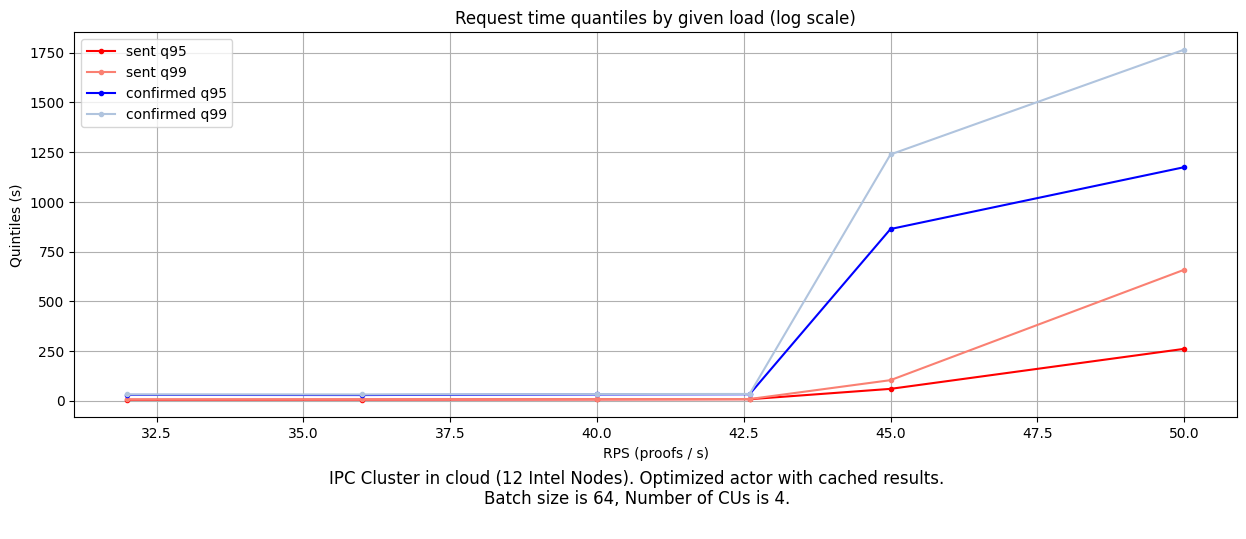

In [402]:
plt.figure(figsize=(15, 5))

loads =              [32,   36,   40,    42.6,  45,     50]

sent_q95 = pd.Series([5513, 6088, 7097, 7969, 60020,  261046]) / 1e3
sent_q99 = pd.Series([7032, 7211, 8421, 8841, 103749, 658518]) / 1e3

confirmed_q95 = pd.Series([29597, 28911, 31937, 33037, 863514,  1174266]) / 1e3
confirmed_q99 = pd.Series([31815, 31947, 33650, 34406, 1238406, 1764969]) / 1e3

plt.plot(loads, sent_q95, label = "sent q95", color="red", marker=".")
plt.plot(loads, sent_q99, label = "sent q99", color="salmon", marker=".")

plt.plot(loads, confirmed_q95, label = "confirmed q95", color="blue", marker=".")
plt.plot(loads, confirmed_q99, label = "confirmed q99", color="lightsteelblue", marker=".")

# plt.yscale("log")
txt="""IPC Cluster in cloud (12 Intel Nodes). Optimized actor with cached results.
Batch size is 64, Number of CUs is 4.
"""
plt.figtext(0.5, -0.1, txt, wrap=True, horizontalalignment='center', fontsize=12)
plt.xlabel('RPS (proofs / s)')
plt.ylabel('Quintiles (s)')
plt.title('Request time quantiles by given load (log scale)')
plt.grid(True)
plt.legend()
plt.show()

In [348]:
for label in list(confirmed):
    if not "cus" in label:
        continue
    total = confirmed[label].sum()
    print(label, total)

labels.cus.0x63752d312d313731363231393339313131380000000000000000000000000000 5467
labels.cus.0x63752d322d313731363231393339313131380000000000000000000000000000 5423
labels.cus.0x63752d302d313731363231393339313131380000000000000000000000000000 5370
labels.cus.0x63752d332d313731363231393339313131380000000000000000000000000000 5308
